# Twitter Study on 2016 Election

__Social media is now an essential part of modern era and people have become used to share their thoughts and opinions on social media such as [Twitter](https://twitter.com/) and [LinkedIn](https://www.linkedin.com/). In this exploratory and preliminary study, we use the approximately 1 million tweets collected between Oct. 19th, 7:30pm and Oct. 20th, 1:30am to try and predict the presidential election outcome. All the tweets are separated into two section: before the 3rd presidential debate and in/post the debate. Note that the debate started ~9:00pm on Oct. 19th.__

__In this study, it is assumed that the collected original tweets (no retweets) can accurately reflect the distribution of people's political opinion among all voters. This is a very crude approximation, which makes this study only qualitatively meaningful. Technology wise, `Python` is used as the main programming language and a `MongoDB` instance was used to store the tweets gathered via [Twitter Streaming API](https://dev.twitter.com/streaming/overview). Standard `Python` tools, such as `NumPy` and `Pandas`, are used for data munging. [NLTK](http://http://www.nltk.org/index.html) was used for word stemming and stop-word removal. The tweets text was analyzed on a `Apache Spark` cluster using `Word2Vec` NLP algorithm (skip-gram model) and `KMeans` clustering algorithm. Finally, the data visualization is carried out using [`plotly`](https://plot.ly/) and [`ggplot`](http://ggplot.yhathq.com).__


## Create A Connection To MongoDB

In [1]:
import pymongo
from pymongo import MongoClient
client = MongoClient('mongodb://152.3.169.27:27017/')

In [2]:
import numpy as np, scipy as sp
import pandas as pd
from pandas import DataFrame as df, Series as ss
import sklearn as sk
import ggplot, seaborn as sns
from pyspark.sql.types import *
from pyspark.sql.functions import *
%matplotlib inline
import random, string

In [3]:
import re
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
ps = PorterStemmer()

In [4]:
tweets = client['db_third_debate']
pre_debate = tweets['pre_debate']
in_debate = tweets['in_debate']

In [5]:
pre_debate.find({"retweeted_status":{"$exists": False}}).count()

114544

In [6]:
in_debate.find({"retweeted_status":{"$exists": False}}).count()

303731

## We Take Only The Original Tweets

In [7]:
pre_debate_tweets = pd.DataFrame(list(pre_debate.find({"retweeted_status":{"$exists": False}}, 
         projection={"_id": False, "text": True, "lang": True, "timestamp_ms": True, "user['location']": True, \
                     "retweet_count": True, "entities.hashtags.text": True})) )
pre_debate_tweets = pre_debate_tweets.dropna(how='any', subset=['text'])

In [8]:
in_debate_tweets = pd.DataFrame(list(in_debate.find({"retweeted_status":{"$exists": False}}, 
         projection={"_id": False, "text": True, "lang": True, "timestamp_ms": True, "user['location']": True, \
                     "retweet_count": True, "entities.hashtags.text": True})) )
in_debate_tweets = in_debate_tweets.dropna(how='any', subset=['text'])

In [9]:
pre_debate_tweets['timestamp_ms'] = pre_debate_tweets['timestamp_ms'].astype(np.int)
pre_debate_tweets['retweet_count'] = pre_debate_tweets['retweet_count'].astype(np.int)
pre_debate_tweets['tweet'] = pre_debate_tweets['text']
in_debate_tweets['timestamp_ms'] = in_debate_tweets['timestamp_ms'].astype(np.int)
in_debate_tweets['retweet_count'] = in_debate_tweets['retweet_count'].astype(np.int)
in_debate_tweets['tweet'] = in_debate_tweets['text']

In [10]:
pre_sample = random.sample(range(0, pre_debate_tweets.shape[0]), 25000)
in_sample = random.sample(range(0, in_debate_tweets.shape[0]), 25000)

In [11]:
# pre_debate_tweets_sample = pre_debate_tweets.iloc[pre_sample].copy()
pre_debate_tweets_sample = pre_debate_tweets[pre_debate_tweets['lang']=="en"].copy()

In [12]:
pre_debate_tweets_sample.shape

(83095, 6)

In [13]:
# in_debate_tweets_sample = in_debate_tweets.iloc[in_sample].copy()
in_debate_tweets_sample = in_debate_tweets[in_debate_tweets['lang']=="en"].copy()

In [14]:
in_debate_tweets_sample.shape

(209463, 6)

## Cleaning The Text

In [15]:
class cleanTweets(object):
    
    acc = 0
    stops = set(stopwords.words("english"))  
    
    @classmethod
    def clearText(self, textString):
        '''
        @param textString: String
        '''
        # Back to plain string
        # s1 = str(textString.decode('unicode_escape').encode('ascii','ignore'))
        
        if type(textString) == 'float':
            textString = str(textString)
        s1 = str(textString.encode('ascii', 'ignore'))
        # Remove URLs
        s1 = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', ' ', s1)
        # Remove @...s
        s1 = re.sub(r'@\w+\b', ' ', s1)
        # Remove hashtags, we will check hash tags later from tweet fields
        s1 = re.sub(r'#\w+\b', ' ', s1)
        # Punctuations, special treatment for "U.S."
        s1 = re.sub(r'U\.S\.', 'US', s1)
        # s1 = re.sub(r'[\"\'\`\,\.\-\:\{\}\!\?\<\>\[\]]|\&amp\;|\\n', ' ', s1)
        s1 = s1.translate(None, string.punctuation)

        # Apply NLTK
        # s1 = ' '.join(nltk.word_tokenize(s1)).strip()
        s1 = nltk.word_tokenize(s1)
        words = [ps.stem(w.lower()) for w in s1 if not w.lower() in self.stops ]
        
        # lowerCaseWords = [w.lower() for w in words]
        self.acc = self.acc + 1
        # print self.acc

        # return ' '.join(lowerCaseWords)
        # return lowerCaseWords
        return words
    
    @classmethod
    def collectHashTags(self, thisEntities):
        j = []
        for tag in thisEntities['hashtags']:
            j.append(str(tag[u'text'].encode('ascii', 'ignore')))
        self.acc = self.acc + 1
        return j

In [16]:
cleanTweets.acc = 0

In [17]:
pre_debate_tweets_sample['text'] = pre_debate_tweets_sample['text'].apply(cleanTweets.clearText)

In [18]:
in_debate_tweets_sample['text'] = in_debate_tweets_sample['text'].apply(cleanTweets.clearText)

In [19]:
pre_debate_tweets_sample['entities'] = pre_debate_tweets_sample['entities'].apply(cleanTweets.collectHashTags)
in_debate_tweets_sample['entities'] = in_debate_tweets_sample['entities'].apply(cleanTweets.collectHashTags)

## Start SparkSession

In [20]:
# spark.conf.set('spark.executor.memory', '6G')

In [21]:
sp_pre_debate_tweets = spark.createDataFrame(pre_debate_tweets_sample)
sp_pre_debate_tweets.cache()
sp_in_debate_tweets = spark.createDataFrame(in_debate_tweets_sample)
sp_in_debate_tweets.cache()

sp_pre_debate_tweets = sp_pre_debate_tweets.withColumnRenamed('entities', 'hashtags')
sp_in_debate_tweets = sp_in_debate_tweets.withColumnRenamed('entities', 'hashtags')

## Applying the `pyspark.ml.feature.Word2Vec` and `pyspark.ml.clustering.KMeans`

In [22]:
from pyspark.ml.feature import Word2Vec
word2Vec = Word2Vec(vectorSize=100, minCount=5, inputCol="text", outputCol="word_vector")

In [23]:
w2v_pre_model = word2Vec.fit(sp_pre_debate_tweets)
w2v_in_model = word2Vec.fit(sp_in_debate_tweets)

In [24]:
w2v_pre_result = w2v_pre_model.transform(sp_pre_debate_tweets)
w2v_pre_result.cache()
w2v_in_result = w2v_in_model.transform(sp_in_debate_tweets)
w2v_in_result.cache()

DataFrame[hashtags: array<string>, lang: string, retweet_count: bigint, text: array<string>, timestamp_ms: bigint, tweet: string, word_vector: vector]

In [25]:
from pyspark.ml.clustering import KMeans
kmeans = KMeans(featuresCol="word_vector", predictionCol="prediction", k=5, seed=1023)
kmeans_pre_model = kmeans.fit(w2v_pre_result)
kmeans_in_model = kmeans.fit(w2v_in_result)

In [26]:
trans_w2v_pre_results = kmeans_pre_model.transform(w2v_pre_result)
trans_w2v_in_results = kmeans_in_model.transform(w2v_in_result)

## Performing Window Aggregation On Prediction

In [27]:
trans_w2v_pre_results = trans_w2v_pre_results.withColumn('time', 
                                 from_unixtime(trans_w2v_pre_results['timestamp_ms']/1000)).sort('time')
trans_w2v_in_results = trans_w2v_in_results.withColumn('time', 
                                 from_unixtime(trans_w2v_in_results['timestamp_ms']/1000)).sort('time')

In [28]:
trans_w2v_pre_results = trans_w2v_pre_results.withColumn('grid', 
                                                         window(trans_w2v_pre_results['time'], "20 minute"))
trans_w2v_in_results = trans_w2v_in_results.withColumn('grid', 
                                                         window(trans_w2v_in_results['time'], "30 minute"))

In [29]:
trans_w2v_pre_results_sql = trans_w2v_pre_results.createOrReplaceTempView("pre_result")

trans_w2v_in_results_sql = trans_w2v_in_results.createOrReplaceTempView("in_result")

In [30]:
pre_result_window = spark.sql("""
  SELECT prediction, COUNT(prediction) AS _count, grid.start
  FROM pre_result
  GROUP BY prediction, grid.start
  ORDER BY prediction, grid.start
""")

pre_result_pdf = pre_result_window.toPandas()

in_result_window = spark.sql("""
  SELECT prediction, count(prediction) AS _count, grid.start
  FROM in_result
  GROUP BY prediction, grid.start
  ORDER BY prediction, grid.start
""")

in_result_pdf = in_result_window.toPandas()

## Visualization on Percentages using `plotly` and `cufflinks`

In [31]:
pre_time = list(pre_result_pdf['start'].unique())
in_time = list(in_result_pdf['start'].unique())
pre_count = []
in_count = []
for itime in pre_time:
    pre_count.append(pre_result_pdf[pre_result_pdf['start']==itime]['_count'].sum())
for itime in in_time:
    in_count.append(in_result_pdf[in_result_pdf['start']==itime]['_count'].sum())

In [32]:
pre_result_pdf['percentage'] = pre_result_pdf['_count']
in_result_pdf['percentage'] = in_result_pdf['_count']
for index, row in pre_result_pdf.iterrows():
    pre_result_pdf.loc[index, 'percentage'] = float(row['_count']) / \
    float(pre_count[pre_time.index(np.datetime64(row['start']))])
    # print float(row['_count']) / float(pre_count[row['prediction']])
for index, row in in_result_pdf.iterrows():
    in_result_pdf.loc[index, 'percentage'] = float(row['_count']) / \
    float(in_count[in_time.index(np.datetime64(row['start']))])

In [33]:
import cufflinks as cf
print cf.__version__
import plotly.plotly as py

0.8.2


In [34]:
pre_result_pdf_pivot = pre_result_pdf.pivot('start', 'prediction')['percentage']
in_result_pdf_pivot = in_result_pdf.pivot('start', 'prediction')['percentage']

In [35]:
pre_result_pdf_pivot.index

DatetimeIndex(['2016-10-19 19:20:00', '2016-10-19 19:40:00',
               '2016-10-19 20:00:00', '2016-10-19 20:20:00',
               '2016-10-19 20:40:00', '2016-10-19 21:00:00'],
              dtype='datetime64[ns]', name=u'start', freq=None)

In [56]:
cf.set_config_file(offline=False, world_readable=True, theme='ggplot')
pre_result_pdf_pivot.iplot(kind='barh',barmode='stack', bargap=.3, filename='cf_pre_debate')

High five! You successfuly sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~zanemarkson/0 or inside your plot.ly account where it is named 'cf_pre_debate'


In [57]:
cf.set_config_file(offline=False, world_readable=True, theme='ggplot')
in_result_pdf_pivot.iplot(kind='barh',barmode='stack', bargap=.3, filename='cf_in_debate')

## What are they ???

### Pre-Debate: 
#### 0. Ad/Report;   1. "observing?"
#### 2. Slightly for Trump;   3. Report;
#### 4. Slightly for Clinton

### In/Post-Debate:
#### 0. Frustration ...;   1. Slightly for Clinton
#### 2. Against Trump;   3. "observing?"
#### 4. Slightly for Trump


In [38]:
for category in range(5):
    print "# ===========> Category {0} <=========== #".format(category)
    trans_w2v_pre_results.filter(trans_w2v_pre_results['prediction']==category).select('tweet').show(10, False)

# ===========> Category 0 <=========== #
+---------------------------------------------------------------------------------------------------------------------------------------+
|tweet                                                                                                                                  |
+---------------------------------------------------------------------------------------------------------------------------------------+
|Mexico regulators ordered bank stress tests to model Trump victory: sources https://t.co/4TffHlncgT brandnaware https://t.co/gDFItyYKvf|
|Mexico regulators ordered bank stress tests to model Trump victory -  https://t.co/j2pLdrTNuy https://t.co/e7qP3zG6eU                  |
|Mexico regulators ordered bank stress tests to model Trump victory: sources https://t.co/zWCjsDZfJr                                    |
|Mexico regulators ordered bank stress tests to model Trump victory: sources: Mexico's financial… https://t.co/kyhLouHnOH #election

In [40]:
for category in range(5):
    print "# ===========> Category {0} <=========== #".format(category)
    trans_w2v_in_results.filter(trans_w2v_in_results['prediction']==category).select('tweet').show(10, False)

# ===========> Category 0 <=========== #
+------------------------------------------------------------------------------------------------------------------------------------------+
|tweet                                                                                                                                     |
+------------------------------------------------------------------------------------------------------------------------------------------+
|#cornmeal crusted #redsnapper and #fries. #fishandchips #presidentialdebate #worstelectionever… https://t.co/6xRxmXDBQM                   |
|Eck. Did it have to start with the F-word? #fauxnews #debatenight                                                                         |
|Only 90 more minutes guys! #wegotthis #debates                                                                                            |
|@dan5656 @Aaron_RS I have a major disagreement with her on Trump.  Glad she survived cancer, obviously.  Cheap s

## Top Ten Word

In [41]:
pre_debate_words = []
for index, row in pre_debate_tweets_sample.iterrows():
    pre_debate_words.append(row['text'])
pre_debate_words_flat = [val for sublist in pre_debate_words for val in sublist]

In [42]:
len(pre_debate_words_flat)

663585

In [43]:
in_debate_words = []
for index, row in in_debate_tweets_sample.iterrows():
    in_debate_words.append(row['text'])
in_debate_words_flat = [val for sublist in in_debate_words for val in sublist]

In [44]:
len(in_debate_words_flat)

1526647

In [45]:
pre_debate_words_df = spark.createDataFrame(pd.DataFrame(pre_debate_words_flat, columns=['word']))
pre_debate_words_window = pre_debate_words_df.createOrReplaceTempView("pre_debate_words_window")

In [46]:
spark.sql("""
  SELECT word, COUNT(word) AS count
  FROM pre_debate_words_window
  GROUP BY word
  ORDER BY count DESC
""").show(10)

+----------+-----+
|      word|count|
+----------+-----+
|     trump|44167|
|     debat|14081|
|presidenti| 9209|
|   tonight| 7812|
|    donald| 7652|
|     watch| 7429|
|     final| 7015|
|   clinton| 6738|
|   hillari| 6452|
|      live| 5518|
+----------+-----+
only showing top 10 rows



In [47]:
in_debate_words_df = spark.createDataFrame(pd.DataFrame(in_debate_words_flat, columns=['word']))
in_debate_words_window = in_debate_words_df.createOrReplaceTempView("in_debate_words_window")

In [48]:
spark.sql("""
  SELECT word, COUNT(word) AS count
  FROM in_debate_words_window
  GROUP BY word
  ORDER BY count DESC
""").show(10)

+----------+-----+
|      word|count|
+----------+-----+
|     trump|94843|
|     debat|22079|
|   hillari|21397|
|    donald|18828|
|   clinton|16445|
|       say|13824|
|presidenti|11677|
|      like|11443|
|      vote|10905|
|     elect|10347|
+----------+-----+
only showing top 10 rows



## Top Ten \#HashTags

In [49]:
pre_debate_tags = []
for index, row in pre_debate_tweets_sample.iterrows():
    pre_debate_tags.append(row['entities'])
pre_debate_tags_flat = [val for sublist in pre_debate_tags for val in sublist]

In [50]:
in_debate_tags = []
for index, row in in_debate_tweets_sample.iterrows():
    in_debate_tags.append(row['entities'])
in_debate_tags_flat = [val for sublist in in_debate_tags for val in sublist]

In [51]:
pre_debate_tags_df = spark.createDataFrame(pd.DataFrame(pre_debate_tags_flat, columns=['tags']))
pre_debate_tags_window = pre_debate_tags_df.createOrReplaceTempView("pre_debate_tags_window")
in_debate_tags_df = spark.createDataFrame(pd.DataFrame(in_debate_tags_flat, columns=['tags']))
in_debate_tags_window = in_debate_tags_df.createOrReplaceTempView("in_debate_tags_window")

In [52]:
spark.sql("""
  SELECT tags, COUNT(tags) AS tag_count
  FROM pre_debate_tags_window
  GROUP BY tags
  ORDER BY tag_count DESC
""").show(30)

+--------------------+---------+
|                tags|tag_count|
+--------------------+---------+
|              debate|    14929|
|         debatenight|     7337|
|              Debate|     2771|
|               Trump|     2594|
|  PresidentialDebate|     1505|
|           ImWithHer|     1323|
|             debates|     1194|
|          TrumpTrain|     1128|
|             Hillary|      967|
|         DebateNight|      795|
|             Clinton|      617|
|                MAGA|      613|
|               trump|      595|
|       DrainTheSwamp|      498|
|      DebateHeadache|      481|
|          debate2016|      470|
|             Debates|      368|
|        Election2016|      350|
|         Debatenight|      306|
|          NeverTrump|      267|
|                 CNN|      235|
|         Debates2016|      234|
|MakeAmericaGreatA...|      201|
|                news|      197|
|        TrumpPence16|      196|
|      HillaryClinton|      193|
|         DonaldTrump|      180|
|RejectedH

In [53]:
spark.sql("""
  SELECT tags, COUNT(tags) AS tag_count
  FROM in_debate_tags_window
  GROUP BY tags
  ORDER BY tag_count DESC
""").show(30)

+------------------+---------+
|              tags|tag_count|
+------------------+---------+
|       debatenight|    57764|
|            debate|    26002|
|       DebateNight|     6000|
|            Debate|     4744|
|             Trump|     4393|
|           Debates|     4263|
|           debates|     3523|
|            NBC4DC|     3446|
|       Debatenight|     2196|
|         ImWithHer|     2062|
|PresidentialDebate|     1922|
|           Hillary|     1708|
|        debate2016|     1239|
|             trump|     1154|
|              MAGA|     1048|
|    DebateHeadache|     1025|
|           Clinton|      801|
|       Debates2016|      761|
|         FactCheck|      715|
|     TrumpDebateCT|      703|
|             NBCCT|      694|
|    HillaryClinton|      659|
|       DonaldTrump|      620|
|      Election2016|      571|
|      ChrisWallace|      505|
|        NeverTrump|      502|
|     DrainTheSwamp|      472|
|         imwithher|      456|
|        TrumpTrain|      433|
|       

## More Visualizations

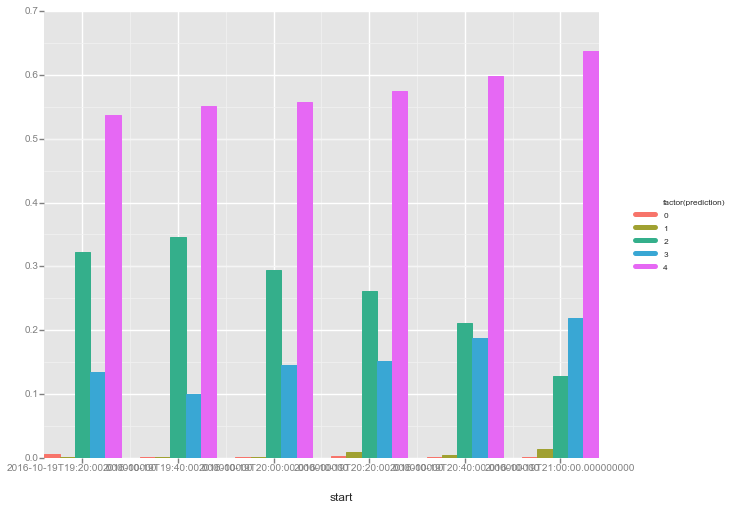

<ggplot: (8780884349761)>

In [54]:
ggplot.ggplot(pre_result_pdf, ggplot.aes(x='start', weight='percentage', fill='factor(prediction)')) \
+ ggplot.geom_bar()

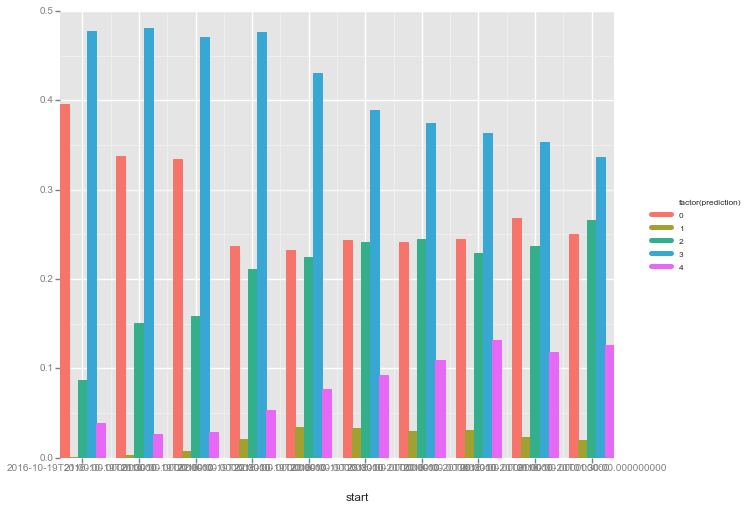

<ggplot: (8780884349605)>

In [55]:
ggplot.ggplot(in_result_pdf, ggplot.aes(x='start', weight='percentage', fill='factor(prediction)')) \
+ ggplot.geom_bar()